## How access to the Gbin file directly from Python

The goal of this Jupyter notebook is to show the way to use to read and write the Gbin file directly from Python, and create dataframe from it.

Now, we start by installing python libraries for this notebook:

In [1]:
# install packages used
%pip install sh
%pip install pandas
%pip install matplotlib
%pip install pyjnius

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Before starting, associated Python and GbinTools written in Java

The jar contains in ```javaLib``` variable can be use to simplify the interface between Python and Java.
The code write in Java define a class named ```Gbin``` that can be use to read and write the Gbin file.
The constructor takes a string as parameter, this string is the complete class name of the MDB or DPC interface.

Before importing jnius package, it is necessary to add the jar file in CLASSPATH environment variable.

In [2]:
import os
import sh
import pandas as pd
import matplotlib.pyplot as plt

# pythonGbin-all.jar is a fat jar and contains all dependencies
javaLib = "../build/libs/pythonGbin-all.jar"
# create a CLASSPATH environment variable before importing jnius
os.environ['CLASSPATH'] = javaLib

from jnius import autoclass, cast

### Compile the Java code

With gradle, you can easly compile the Java code and produce a fatJar file.

The advantage of a fatJar file is that it contains all the dependencies, so import this fatJar permits to have all CNES librairies accessible in one jar file.

In [3]:
# create the fatjar with gradle
def compile():
    current_directory = os.getcwd()
    os.chdir("..")
    sh.Command('./gradlew')('shadowJar')
    os.chdir(current_directory)

# Complile only if the jar file is not aleady present
if not os.path.exists(javaLib):
    compile()

It can be necessary to change Java dependancies (use another version of the MDB or DPC).
In CU4, we use nss-bl which group all dependancies defined by DPCC.
If you want to change the version of nss-bl, or add another dependancy, you can modify the file ```build.gradle``` and add the dependancy in the ```dependencies``` section.
In the example, the dependancy is 
```
dependencies {
    implementation 'gaia.cu4:nss-bl:21.4'
}
```

### Prepare GbinTools class

GbinTools class include in src directory simplify:
- create new instance of MDB or DPC class specified in parameter of the constructor (the method ``ǹewInstance()`` of ```GbinTools``` class)
- read Gbin (method ```List<GaiaRoot> readGbin(String)``` where the String is the path of the Gbin file)
- and write Gbin (method ```void writeGbin(String, List<T extendsGaiaRoot>)``` where the String is the path of the Gbin file and the ```List<T extends GaiaRoot>``` is the list of GaiaRoot to write in the Gbin file)

So, I start by associate the Java Class to a Python variable.

Important note: PyJnius not permit define templates when you create a java object. So for ```GbinTools<T extends GaiaRoot>``` T is ignore and all return are GaiaRoot objects.
So it's necessary to cast the return of ``ǹewInstance()`` method and each object in the list return by ```readGbin()``` method.

In [4]:
# List is usefull to create a list of datamodels objects
List = autoclass("java.util.ArrayList")
# GbinTools is the utility class
GbinTools = autoclass("gaia.cu4.tools.GbinTools")

I create an instance of GbinTools class for StarObject (only need to read StarObject Gbin file), and Transit (because I want to create some transit to show how to write Gbin file).

In [5]:
# Create an instance of GbinTools for StarObject
dmStarObject = "gaia.cu4.nss.epochparams.dm.StarObject"
gbinToolsStarObject = GbinTools(dmStarObject)
# Create an instance of GbinTools for Transit
dmTransit = "gaia.cu4.nss.epochparams.dm.Transit"
gbinToolsTransit = GbinTools(dmTransit)

log4j:WARN No appenders could be found for logger (gaia.cu1.tools.util.SysUtils).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.


As python object, you can easly list the methods of the java object:

In [6]:
# create a star object (without cast, you have a GaiaRoot object)
so = cast(dmStarObject, gbinToolsStarObject.newInstance())
print("StarObject methods:")
# list all getters methods of StarObject
for method in dir(so):
    if method.startswith("get"):
        print(method)

StarObject methods:
getA0
getAbp
getAg
getAlpha0
getArp
getAstromSource
getBestVariabilityTypes
getBpMean
getClass
getCompleteSource
getCreationDate
getCu7ClassificationResult
getCu7Periodicity
getDelta0
getDistance
getEBPminRP
getEligibilityFlag
getExcessNoise
getFeH1
getFlagSB2
getGMean
getGRvs
getGRvsError
getGogPeriod
getGogProba
getHasCompleteSource
getIsSB2
getLogG1
getMass
getMatchedObsWithMultiPeak
getMatchedPeaks
getMatchedSecPeaks
getMg
getParamMaxValues
getParamMinValues
getParamOutOfRangeValues
getPhotPeriodicVariability
getPhotometricPeriodicity
getPhotometricVariabilityFlag
getProbAstrometricNSS
getProbClassifNSS
getProbEclipsingNSS
getProbSpectroscopicNSS
getR0
getRadVelSpeBar
getRadius
getRatioSpectroComponents
getRefEpochTransitDay
getRpMean
getRuwe
getScanAngleSignalSignificance
getSolutionId
getSosEB
getSourceId
getTeff1
getTemplateFeH
getTemplateLogg
getTemplateTeff
getToProcessFlags
getTransitData
getTransits
getVariabilityClassification


### Create a Gbin file

The code above :
- create 10 StarObject object, fill with random value (with the method defined in StarObject) and add the to the list, and set delta0 to 1.5 for all starobjects.
- add 5 Transit to each starobject, and define an unique the transitId for each transit, and add them to the current starobject.
- add the starobject to the list of starobject
 
When the list is filled, I write the list in the Gbin file.

In [7]:
# I instanciate a java ArrayList
gbinList = List()
print(f"Create a list of {dmStarObject} objects:")
for i in range(10):
    # The object return is GaiaRoot, so cast it to StarObject
    so = cast(dmStarObject, gbinToolsStarObject.newInstance())
    so.fillWithRandomValues()
    # Just to show, it is possible to set a value in the object
    so.setDelta0(1.5)
    # create a Transit[] of size 5 filled with 5 Transit objects to fill
    tlist = list()
    for j in range(5):
        tr = cast(dmTransit, gbinToolsTransit.newInstance())
        tr.setTransitId(j + i*100 + 999000)
        tlist.append(tr)
    so.setTransits(tlist)
    # Just to show, it is possible to get a value from the object
    print("* sourceId:", so.getSourceId(), "transitId[4]:", so.getTransits()[4].getTransitId())
    gbinList.add(so)
gbinToolsStarObject.writeGbin("test.gbin", gbinList)

Create a list of gaia.cu4.nss.epochparams.dm.StarObject objects:
* sourceId: 7772540055725277184 transitId[4]: 999004
* sourceId: 2478121088123404288 transitId[4]: 999104
* sourceId: -9141386952329658368 transitId[4]: 999204
* sourceId: 4865631423001788416 transitId[4]: 999304
* sourceId: 8831263100645670912 transitId[4]: 999404
* sourceId: 5434649581096796160 transitId[4]: 999504
* sourceId: -7516880512523173888 transitId[4]: 999604
* sourceId: -3488865843654164480 transitId[4]: 999704
* sourceId: -3813906769592188928 transitId[4]: 999804
* sourceId: 3538611048229634048 transitId[4]: 999904


### Read a Gbin file

Now we can open and read the Gbin file create above. No cast need for Transit because StarObject return the class Transit[]
Last point, PyJnius convert array type in java to python List() automatically. But java List (like ArrayList) are not converted, so you need to use method of Java List object (like ```get(int)``` or ```size()```) to extract ibject from the java list.

In [8]:
print(f"Read the list of {dmStarObject} objects create before:")
listRead = gbinToolsStarObject.readGbin("test.gbin")
for i in range(listRead.size()):
    # need to cast the object to StarObject, CU1 tools return GaiaRoot
    so = cast(dmStarObject, listRead.get(i))
    # the java array is automatically convert to a python list
    transitSize = len(so.getTransits())
    print("+ sourceId:", so.getSourceId(), "transitsId:", [so.getTransits()[j].getTransitId() for j in range(transitSize)])

Read the list of gaia.cu4.nss.epochparams.dm.StarObject objects create before:
+ sourceId: 7772540055725277184 transitsId: [999000, 999001, 999002, 999003, 999004]
+ sourceId: 2478121088123404288 transitsId: [999100, 999101, 999102, 999103, 999104]
+ sourceId: -9141386952329658368 transitsId: [999200, 999201, 999202, 999203, 999204]
+ sourceId: 4865631423001788416 transitsId: [999300, 999301, 999302, 999303, 999304]
+ sourceId: 8831263100645670912 transitsId: [999400, 999401, 999402, 999403, 999404]
+ sourceId: 5434649581096796160 transitsId: [999500, 999501, 999502, 999503, 999504]
+ sourceId: -7516880512523173888 transitsId: [999600, 999601, 999602, 999603, 999604]
+ sourceId: -3488865843654164480 transitsId: [999700, 999701, 999702, 999703, 999704]
+ sourceId: -3813906769592188928 transitsId: [999800, 999801, 999802, 999803, 999804]
+ sourceId: 3538611048229634048 transitsId: [999900, 999901, 999902, 999903, 999904]


### Usage example

We read a real Gbin (DR3 data convert by CNES to DR4 StarObject format), we store necessary data into a pandas dataframe and we plot the result.

In [9]:
print(f"Read the list of {dmStarObject} objects from DR3 (with DR4 format):")
# define columns of the dataframe without data
df = pd.DataFrame(columns=['sourceId', 'alpha0', 'delta0', 'alpha', 'alphaStarError', 'delta', 'deltaStarError', 'varpi', 'transitSize'])
listRead = gbinToolsStarObject.readGbin("dr3_data_in_dr4_format.gbin")
for i in range(listRead.size()):
    so = cast(dmStarObject, listRead.get(i))
    # add the data in the dataframe
    df.loc[i] = [so.getSourceId(), so.getAlpha0(), so.getDelta0(), so.getAstromSource().getAlpha(), 
                    so.getAstromSource().getAlphaStarError(), so.getAstromSource().getDelta(), 
                    so.getAstromSource().getDeltaError(), so.getAstromSource().getVarpi(), len(so.getTransits())]
## Plot de pmra vs pmdec et obstime vs al dans le transit
df

Read the list of gaia.cu4.nss.epochparams.dm.StarObject objects from DR3 (with DR4 format):


sourceId    alpha0    delta0     alpha  alphaStarError     delta  \
0    1.884977e+18  6.046206  0.497771  6.046206        0.014337  0.497771   
1    1.886091e+18  6.028846  0.526760  6.028846        0.011800  0.526760   
2    1.886805e+18  6.018064  0.546530  6.018064        0.009224  0.546530   
3    1.889831e+18  6.012885  0.552780  6.012885        0.009538  0.552780   
4    1.889903e+18  6.009809  0.558002  6.009809        0.023018  0.558002   
..            ...       ...       ...       ...             ...       ...   
193  2.837885e+18  6.114567  0.372347  6.114567        0.010900  0.372347   
194  2.839516e+18  6.085661  0.427123  6.085661        0.014802  0.427123   
195  2.845191e+18  6.066612  0.462574  6.066612        0.026931  0.462574   
196  1.890234e+18  5.996937  0.579531  5.996937        0.010608  0.579531   
197  1.975487e+18  5.790679  0.828767  5.790679        0.010024  0.828767   

     deltaStarError     varpi  transitSize  
0          0.015969  0.834687        789.0  
1          0.013588  1.011918        783.0  
2          0.008307  1.816803        863.0  
3          0.008697  0.431167       1046.0  
4          0.021404  7.520184       1188.0  
..              ...       ...          ...  
193        0.011638  1.461041        616.0  
194        0.012062  1.466138        752.0  
195        0.022524  1.123415        757.0  
196        0.008791  1.282664       1149.0  
197        0.010898  0.431023       1009.0  

[198 rows x 9 columns]

Text(0.5, 1.0, 'Sources by healpix order 1')

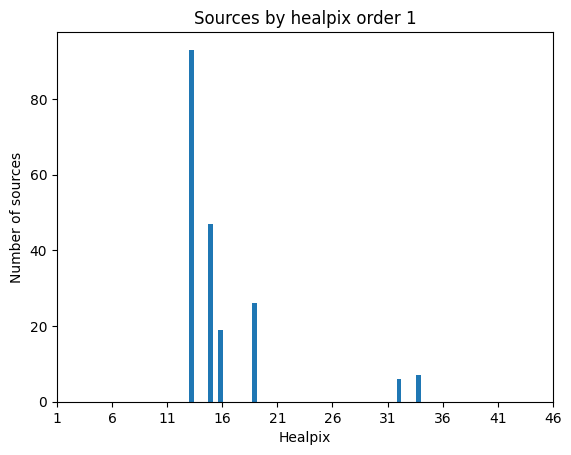

In [10]:
# an example of plot, plot the number of sources by healpix order 1 in the dataframe
ax = df.apply(lambda x: int(x['sourceId']) >> 57, axis=1).hist(bins=48)
ax.set_xticks(range(1, 49, 5))
ax.grid(False)
ax.set_xlabel('Healpix')
ax.set_ylabel('Number of sources')
ax.set_title('Sources by healpix order 1')

<Axes: xlabel='alpha0', ylabel='delta0'>

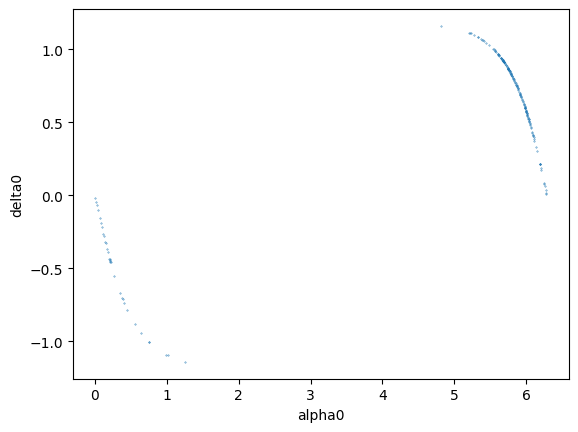

In [11]:
# alpha0 vs delta0 for all the dataframe
df.plot.scatter(x='alpha0', y='delta0', s=0.1)

In [12]:
# find the index of the source with the maximum number of transits
maxNbTransits = df["transitSize"].idxmax()
# get the corresponding StarObject
so = cast(dmStarObject, listRead.get(i))
print(f"{so.getSourceId()} has {len(so.getTransits())} transits")
print("Getters methods of Transit:")
transits = so.getTransits()
for method in dir(transits[0]):
    if method.startswith("get"):
        print(method)


1975487495050470144 has 1009 transits
Getters methods of Transit:
getBlackListed
getBpFlux
getBpFluxError
getBrightnessRatio
getCentroidPosAc
getCentroidPosAl
getCentroidPosErrorAc
getCentroidPosErrorAl
getClass
getCovarianceV1V2
getCu6OutlierStatus
getCu7BpFlux
getCu7BpFluxError
getCu7Bpflags
getCu7GFlux
getCu7GFluxError
getCu7Gflags
getCu7RpFlux
getCu7RpFluxError
getCu7Rpflags
getGFlux
getGFluxError
getObsTime
getParamMaxValues
getParamMinValues
getParamOutOfRangeValues
getRpFlux
getRpFluxError
getRvsFlux
getRvsFluxError
getScanPosAngle
getSigmaVR1
getSigmaVR2
getSigmaVSini1
getSigmaVSini2
getSolutionId
getSpectroObsTime
getTransitId
getVR1
getVR2
getVSini1
getVSini2
getVarPiFactorAc
getVarPiFactorAl


In [13]:
# create a dataframe with all transits
dfTransits = pd.DataFrame(columns=['transitId', 'ccdId', 'obsTime', 'centroidPosAl'])
for i in range(len(transits)):
    t = transits[i]
    transitId = int(t.getTransitId())
    dfTransits.loc[i] = [transitId >> 4, transitId & 0x0F, t.getObsTime(), t.getCentroidPosAl()]

dfTransits

transitId  ccdId      obsTime  centroidPosAl
0     1.560958e+16    3.0 -1060.235188       9.887268
1     1.560958e+16    4.0 -1060.235132       5.917974
2     1.560958e+16    5.0 -1060.235076       3.571341
3     1.560958e+16    6.0 -1060.235019       2.296673
4     1.560958e+16    7.0 -1060.234963       1.849874
...            ...    ...          ...            ...
1004  1.251929e+17    7.0   921.517350     -11.226224
1005  1.251929e+17    8.0   921.517406     -11.160816
1006  1.251929e+17    9.0   921.517462     -11.235148
1007  1.251929e+17   10.0   921.517518     -11.300056
1008  1.251929e+17   11.0   921.517575     -11.406276

[1009 rows x 4 columns]

Text(0.5, 1.0, 'Centroid position vs obsTime')

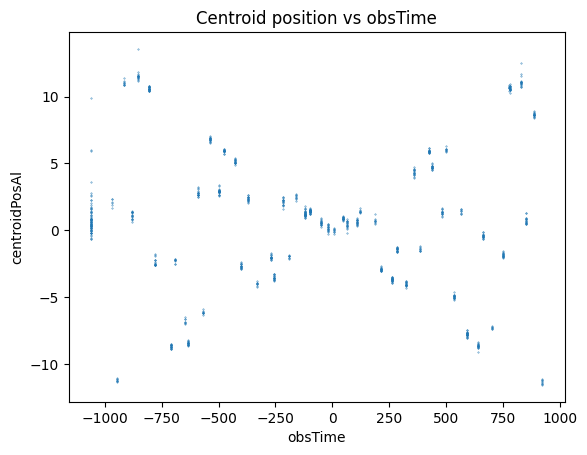

In [14]:
# plot centroid position vs obsTime
ax = dfTransits.plot.scatter(x='obsTime', y='centroidPosAl', s=.1)
ax.set_title('Centroid position vs obsTime')